# **Heart Disease**

## ***Importing the necessary libraries***

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import csv
import itertools
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC,SVC
from sklearn.multiclass import OneVsRestClassifier
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LassoCV,LogisticRegression,SGDClassifier
from sklearn.naive_bayes import GaussianNB,BernoulliNB
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,BaggingClassifier,AdaBoostClassifier,GradientBoostingClassifier,VotingClassifier,StackingClassifier
from sklearn.feature_selection import chi2,SelectKBest,SelectFromModel,RFE,VarianceThreshold
from sklearn.metrics import confusion_matrix,precision_recall_curve,average_precision_score,roc_curve,auc,f1_score,accuracy_score,\
classification_report,multilabel_confusion_matrix, roc_auc_score,precision_recall_fscore_support
from sklearn.model_selection import cross_val_score,train_test_split,StratifiedKFold,GridSearchCV
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler,LabelEncoder,LabelBinarizer
from scipy import interp
from itertools import cycle
plt.style.use('ggplot');
import sys
if ("/your/path/to/xelatex") not in sys.path:
    print('adding path') # I just add this to know if the path was present or not.
    sys.path.append("/your/path/to/xelatex")

adding path


# **Data**

### *Reading the data*

In [2]:
with open('/content/drive/MyDrive/AI&ML internship /heart Disease/cleve.mod', 'r') as in_file:
    lines = in_file.read().splitlines()[20:]
    stripped = [line.replace(","," ").split() for line in lines]
    grouped = zip(*[stripped]*1)
    with open('cleve.csv', 'w') as out_file:
        writer = csv.writer(out_file)
        for group in grouped:
            writer.writerows(group)

names = [
    'age', 'sex','cp','trestbps','chol','fbs','restecg','thalach',
    'exang','oldpeak','slope','ca','thal','target'
]
df = pd.read_csv('cleve.csv',header=None)
df.drop(13, inplace=True,axis=1)
df.columns = names
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,male,angina,145.0,233.0,true,hyp,150.0,fal,2.3,down,0.0,fix,H
1,67.0,male,asympt,160.0,286.0,fal,hyp,108.0,true,1.5,flat,3.0,norm,S2
2,67.0,male,asympt,120.0,229.0,fal,hyp,129.0,true,2.6,flat,2.0,rev,S1
3,37.0,male,notang,130.0,250.0,fal,norm,187.0,fal,3.5,down,0.0,norm,H
4,41.0,fem,abnang,130.0,204.0,fal,hyp,172.0,fal,1.4,up,0.0,norm,H


### **Data Description**


* **age**: The age of the person in years
* **sex**: Gender (1:male, 0:female)
* **cp**: Type of chest pain (typical angina, atypical angina, non — anginal pain,asymptotic)
* **trestbps**: The resting blood pressure value of in mmHg
* **chol**: The the serum cholesterol in mg/dl (unit)
* **fbs** : True: fasting blood sugar>120mg/dl, False:otherwise
* **restecg**: The resting electrocardiographic results (normal,having ST-T  wave abnormality,left ventricular hyperthrophy)
* **thalach**: The the maximum heart rate achieved by an individual.
* **exang**: Exercise induced angina(True:Yes, False:No)
* **oldpeak**: ST depression induced by exercise relative to rest
* **slope:**: Peak exercise ST segment(upsloping,flat,downsloping)
* **ca:**: Number of major vessels (0–3) colored by flourosopy
* **thal**:Thalassemia disorder(normal,fixed defect,reversible defect)
* **target**:(H = absence , [S1, S2, S3, S4] = present.)



### Data Summary and cleaning

In [3]:
df.shape

(303, 14)

In [4]:
df.dtypes

age         float64
sex          object
cp           object
trestbps    float64
chol        float64
fbs          object
restecg      object
thalach     float64
exang        object
oldpeak     float64
slope        object
ca           object
thal         object
target       object
dtype: object

In [5]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-null    object 
 2   cp        303 non-null    object 
 3   trestbps  303 non-null    float64
 4   chol      303 non-null    float64
 5   fbs       303 non-null    object 
 6   restecg   303 non-null    object 
 7   thalach   303 non-null    float64
 8   exang     303 non-null    object 
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    object 
 11  ca        303 non-null    object 
 12  thal      303 non-null    object 
 13  target    303 non-null    object 
dtypes: float64(5), object(9)
memory usage: 172.8 KB


 *For the sake of EDA,let **H** a healthy person and **S1,S2,S3,S4** represent sick patients and also create a copy of the dataframe, so that it can be used later*

In [6]:
df['ca'].replace(to_replace = '?', value = 4, inplace=True)
df['ca'] = pd.to_numeric(df['ca'])
df_copy = df.copy()
df['target'].replace(['S[0-9]', 'H'], [1,0], regex=True, inplace=True)

In [7]:
print(f"Dataset shape before dropping duplicates: {df.shape}")
df = df.drop_duplicates()
df_copy = df_copy.drop_duplicates()
print(f"Dataset shape after dropping duplicates: {df.shape}")

Dataset shape before dropping duplicates: (303, 14)
Dataset shape after dropping duplicates: (302, 14)


*No **Nan** values in the data.*

In [8]:
df.isna().sum().sum()

0

# **EDA**

## **Categorical Variables**

### *Target*



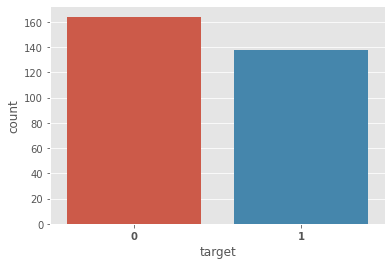

In [9]:
sns.countplot(data = df, x='target');
plt.xticks(rotation=0, weight='bold');

### *Sex*

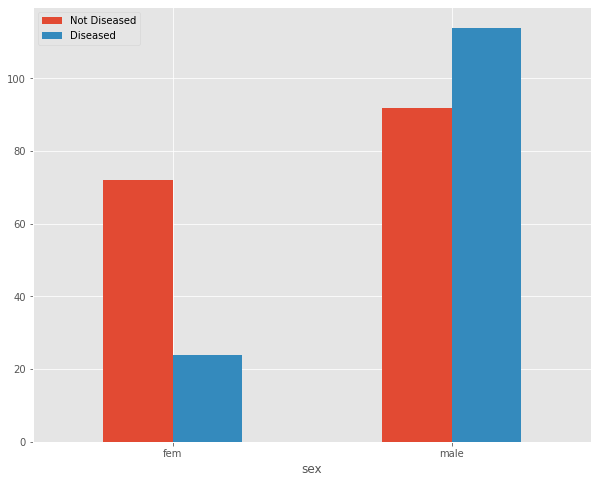

In [10]:
pd.crosstab(index=df.sex, columns=df.target).plot(kind='bar',figsize=(10,8))
plt.xticks(rotation=0)
# plt.xlabel('False: [fbs<120]  True:[fbs > 120]', weight='bold')
plt.legend(['Not Diseased', 'Diseased']);

### *FBS*

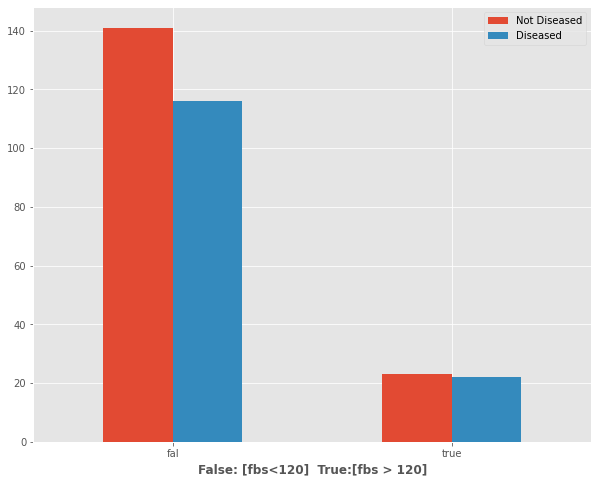

In [11]:
pd.crosstab(index=df.fbs, columns=df.target).plot(kind='bar',figsize=(10,8))
plt.xticks(rotation=0)
plt.xlabel('False: [fbs<120]  True:[fbs > 120]', weight='bold')
plt.legend(['Not Diseased', 'Diseased']);

### *Exang*

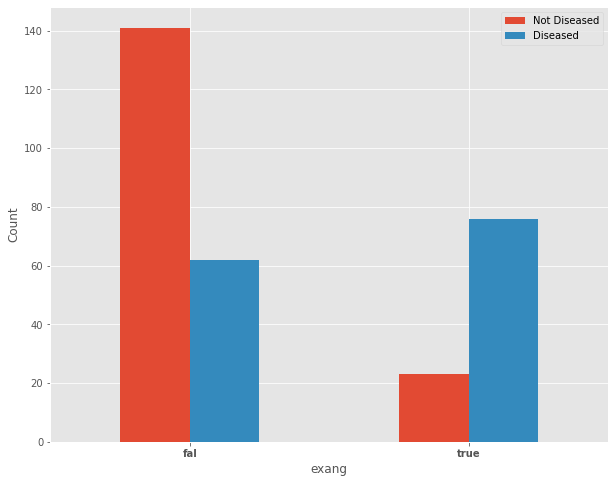

In [12]:
pd.crosstab(index=df.exang, columns = df.target).plot(kind='bar',figsize=(10,8))
plt.xticks(rotation=0,weight='bold')
plt.legend(['Not Diseased', 'Diseased']);
plt.ylabel('Count');

### *Chest pain type*

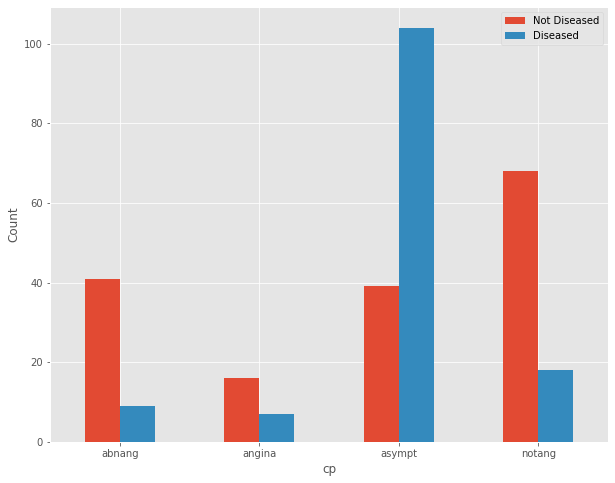

In [13]:
pd.crosstab(index=df.cp, columns= df.target).plot(kind='bar',figsize=(10,8))
plt.xticks(rotation=0)
plt.legend(['Not Diseased', 'Diseased']);
plt.ylabel('Count');

### Number of vessels colored by fluroscopy (ca)

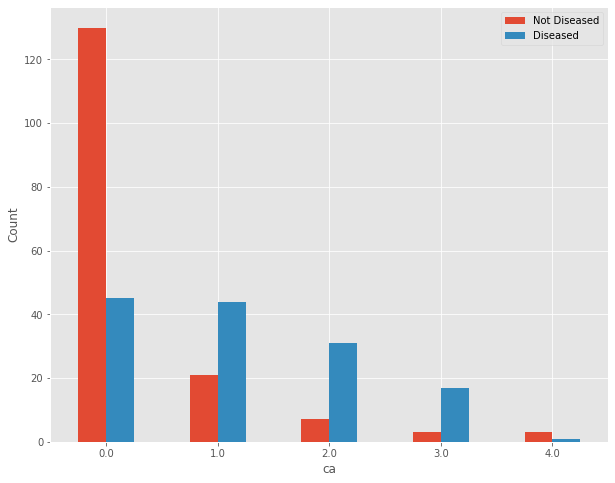

In [14]:
pd.crosstab(index=df.ca, columns= df.target).plot(kind='bar',figsize=(10,8))
plt.xticks(rotation=0)
plt.legend(['Not Diseased', 'Diseased']);
plt.ylabel('Count');

### Slope of the Peak exercise ST segment (slope)

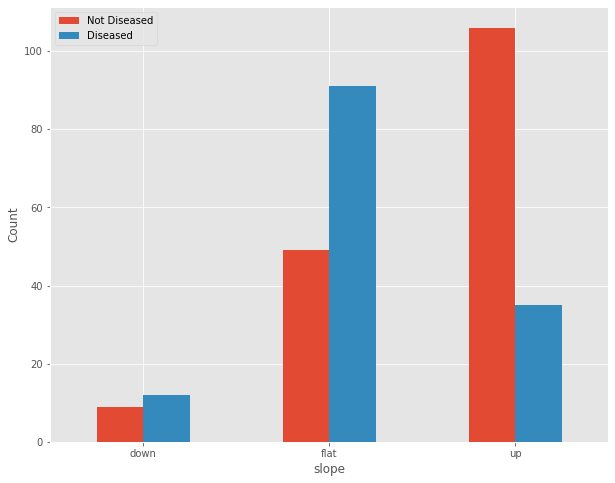

In [15]:
pd.crosstab(index=df.slope, columns= df.target).plot(kind='bar',figsize=(10,8))
plt.xticks(rotation=0)
plt.legend(['Not Diseased', 'Diseased']);
plt.ylabel('Count');

### *Resting ECG*

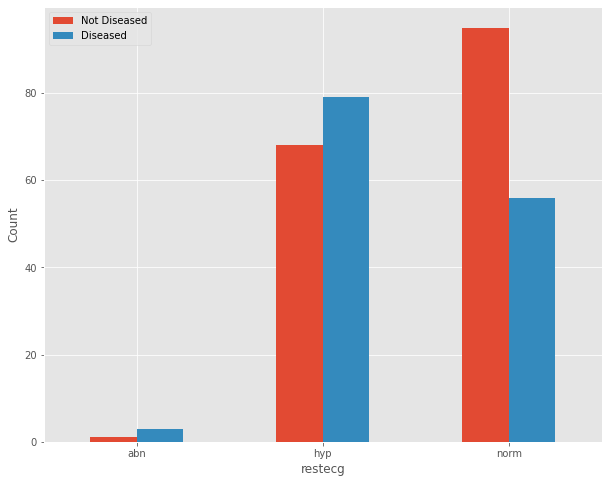

In [16]:
pd.crosstab(index=df.restecg, columns= df.target).plot(kind='bar',figsize=(10,8))
plt.xticks(rotation=0)
plt.legend(['Not Diseased', 'Diseased']);
plt.ylabel('Count');

### *Thal*

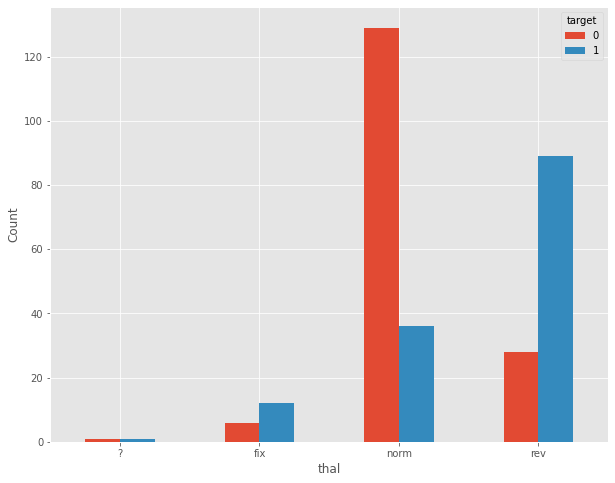

In [17]:
pd.crosstab(index=df.thal, columns= df.target).plot(kind='bar',figsize=(10,8))
plt.xticks(rotation=0)
plt.ylabel('Count');

### **Observations**

1.   Men are at greater risk of heart disease than pre-menopausal women. Once past menopause, it has been argued that a woman’s risk is similar to a man’s although more recent data from the WHO and UN disputes this. If a female has diabetes, she is more likely to develop heart disease than a male with diabetes.

2.   Suprisingly, individuals with fbs less than 120 are more likely to be diseased than the people with higher levels of blood sugar level. This wasn't the expected outcome, as higher blood sugar levels usually corresponds to higher blood pressure, which in-turn increases the risk of contracting a heart disease.

3. The pain or discomfort associated with angina usually feels tight, gripping or squeezing, and can vary from mild to severe. Angina is usually felt in the center of your chest but may spread to either or both of your shoulders, or your back, neck, jaw or arm. It can be seen from the bar chart,that the chances of people being diseased when the chest pain is caused due to exercise is very similiar to the opposite scenario.

4. Most of the heart disease patients are found to have asymptomatic chest pain. These group of people might show atypical symptoms like indigestion, flu or a strained chest muscle. A asymptomatic attack, like any heart attack, involves, blockage of blood flow to your heart and possible damage to the heart muscle.

6. The more the number of major vessels, the lesser are the chances of getting a heart disease. The same can be observed, from the bar chart of **ca** column, where the number of vessels coloured by fluroscopy is inversely proportional to the number of positive cases.

7.  In general, the occurrence of horizontal or down-sloping ST-segment depression at a lower workload (calculated in METs) or heart rate indicates a worse prognosis and higher likelihood of multi-vessel disease. Patients gaving ST-segment elevation > 1 mm are frequently referred urgently for coronary angiography.

6.  For people at low risk of cardiovascular disease, the USPSTF concludes with moderate certainty that the potential harms of screening with resting or exercise ECG equal or exceed the potential benefits. For people at intermediate to high risk, current evidence is insufficient to assess the balance of benefits and harms of screening.


## **Continuous Variables**

### *Univariate Analysis*

In [18]:
cont_cols = ['age','trestbps','chol','thalach','oldpeak']
for col in cont_cols:
  print(f"{col} skew: {df[col].skew()}")

age skew: -0.20374327959596902
trestbps skew: 0.7165414326647316
chol skew: 1.147332413980798
thalach skew: -0.5326712468229612
oldpeak skew: 1.2661727209102194


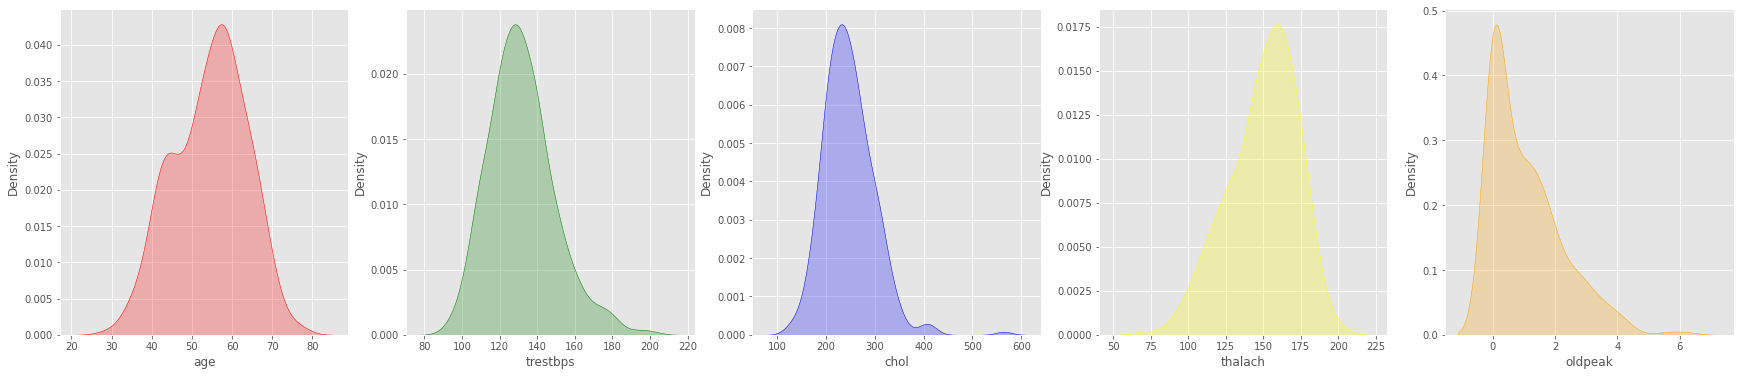

In [19]:
color = ['r','g','b','yellow','orange']
f, ax = plt.subplots(1,5, figsize=(30,6))

for i,ax in enumerate(ax):
  x = pd.Series(df[cont_cols[i]], name=cont_cols[i])
  g = sns.kdeplot(x, shade=True, color=color[i],ax=ax)


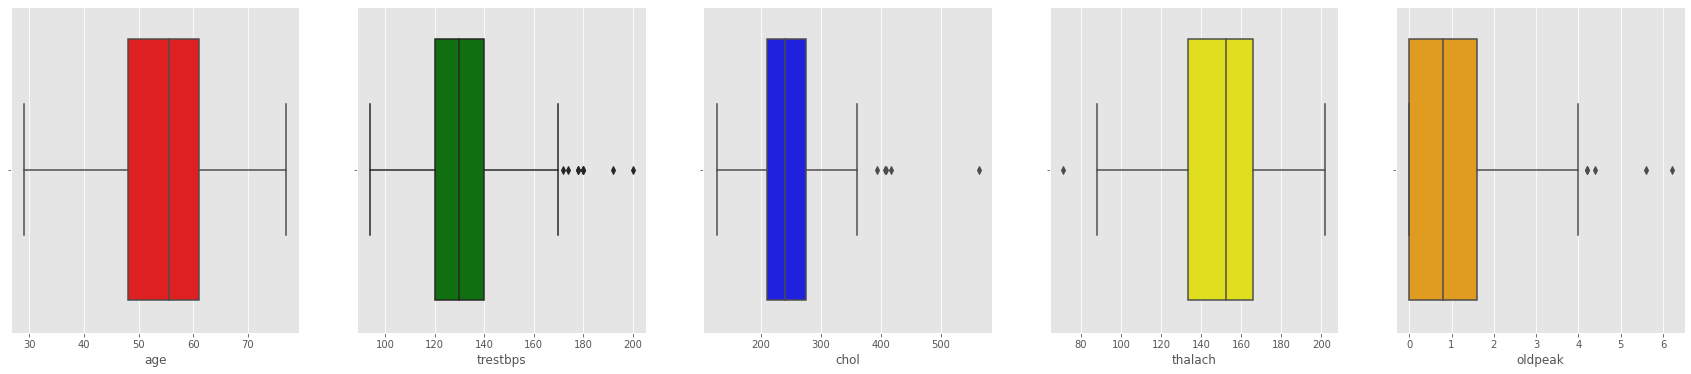

In [20]:
f, ax = plt.subplots(1,5, figsize=(30,6))
for i,ax in enumerate(ax):
  sns.boxplot(x = cont_cols[i],data = df, ax=ax, color = color[i]);


#### **Observations**



1.   Trestbps, chol and oldpeak are right skewed.

2.   Thalach is left skewed.

3. Trestbps, chol and oldpeak features have outliers on the right hand side.

4. Thalach has outliers on the left hand side


### *Bivariate Analysis*

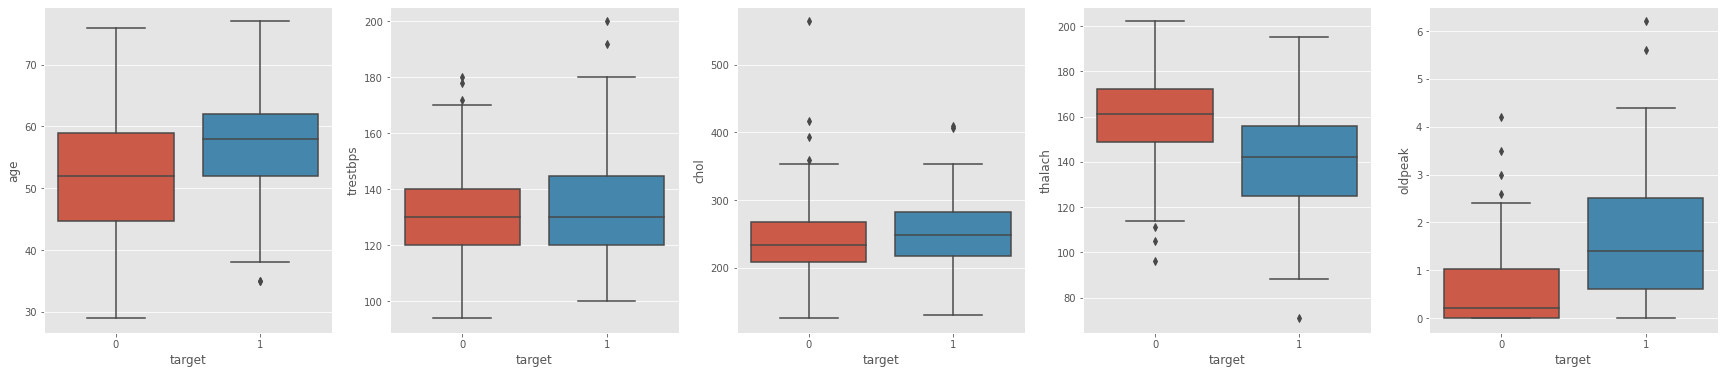

In [21]:
f, ax = plt.subplots(1,5,figsize=(30, 6));
sns.boxplot(x="target", y="age", data=df,ax=ax[0]);
sns.boxplot(x="target", y="trestbps", data=df,ax = ax[1]);
sns.boxplot(x="target", y="chol", data=df,ax = ax[2]);
sns.boxplot(x="target", y="thalach", data=df,ax = ax[3]);
sns.boxplot(x="target", y="oldpeak", data=df,ax = ax[4]);


#### **Observations**



1.   Age is one of the most important risk factor in developing cardiovascular or heart diseases, with approximately a tripling of risk with each decade of life. Coronary fatty streaks can begin to form in adolescence. It is estimated that 82 percent of people who die of coronary heart disease are 65 and older. Simultaneously, the risk of stroke doubles every decade after age 55.

2.   Over time, high blood pressure can damage arteries that feed your heart. High blood pressure that occurs with other conditions, such as obesity, high cholesterol or diabetes, increases your risk even more.

3. A high level of low-density lipoprotein (LDL) cholesterol (the “bad” cholesterol) is most likely to narrow arteries. A high level of triglycerides, a type of blood fat related to your diet, also ups your risk of a heart attack. However, a high level of high-density lipoprotein (HDL) cholesterol (the “good” cholesterol) lowers your risk of a heart attack.

4. Oldpeak is greater in diseased patients as compared to the non-diseased patients



### *Multivariate Analysis*



1.   Since, the target feature represents the presence or absence of a heart diesease, let's find the correlation of the features w.r.t. to the target.
2.   In order to do so, we need to label encode our categorical features



In [22]:
df = df_copy
df['sex'].replace(to_replace=['male','fem'], value = [1,0],inplace=True)
df['cp'].replace(to_replace = ['asympt','abnang','notang','angina'], value = [0,1,2,3], inplace=True)
df['fbs'].replace(to_replace = ['true','fal'], value = [1,0],inplace=True)
df['restecg'].replace(to_replace = ['hyp', 'norm','abn'], value = [0,1,2], inplace=True)
df['exang'].replace(to_replace = ['fal','true'], value = [0,1], inplace=True)
df['slope'].replace(to_replace = ['down','flat','up'], value = [0,1,2], inplace=True)
df['thal'].replace(to_replace = ['?','fix','norm','rev'], value = [0,1,2,3], inplace=True)
df['target'].replace(to_replace = ['H','S1','S2','S3','S4'],value = [0,1,2,3,4], inplace=True)

In [23]:
df.corr()['target']

age         0.222890
sex         0.225511
cp         -0.417746
trestbps    0.158089
chol        0.070868
fbs         0.059274
restecg    -0.133425
thalach    -0.415298
exang       0.397496
oldpeak     0.504919
slope      -0.378722
ca          0.454953
thal        0.330199
target      1.000000
Name: target, dtype: float64

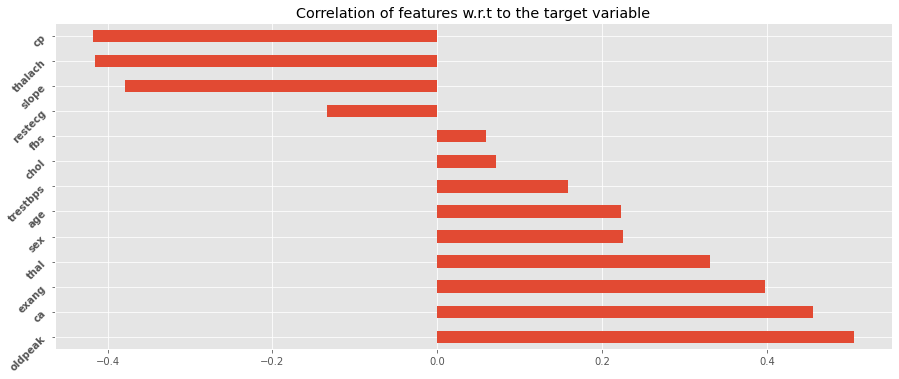

In [24]:
df.corr()['target'][:-1].sort_values(ascending=False).plot(kind='barh', figsize = (15,6))
plt.yticks(rotation=45, weight='bold');
plt.title('Correlation of features w.r.t to the target variable');

*Correlation between features*

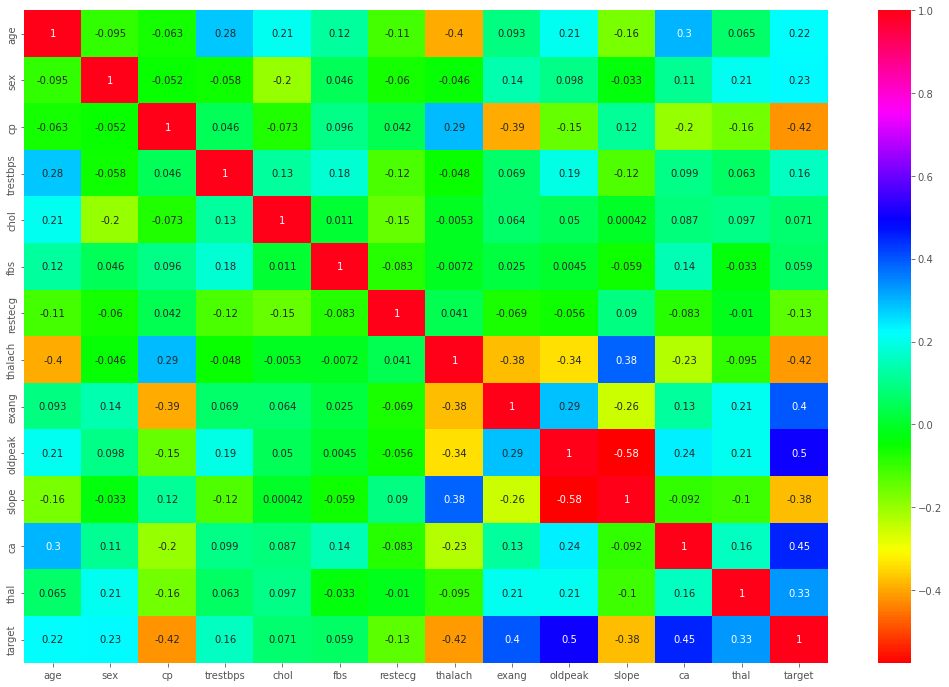

In [25]:
fig = plt.figure(figsize = (18,12))
ax = sns.heatmap(df.corr(), annot=True,cmap='hsv');

#### **Observations**

1.   None of the features have a strong positive or negative correlation with the target variable.

2.   Fasting blood sugar seems to be uncorrleated with the patient being diseased, which is a bit suprising.

3.   Exang and oldpeak are slighlty negatively correlated with the target variable.

4.   Thalch and cp are slightly positively correlated with the target variabe.

5. None of the features are higly correlated, and hence no such features need to be dropped to avoid multi-collinearity.



# **Outlier-Detection**

***Since, we don't have a lot of data for training and testing our data, let's use the Inter-Quartile Range (IQR) for the detection of outlier***

**Standard Deviation:**
![](https://qph.fs.quoracdn.net/main-qimg-a86744ea6f27735b381e097bed60e048.webp)  

**Interquartile Range:**
![](http://www.statisticshowto.com/wp-content/uploads/2012/03/iqr.jpg)

* Consider any feature from the dataset. Below, is the distribution of the **chol** feature prior to removal of it's outliers.

* The area shaded in red, represents the outliers.

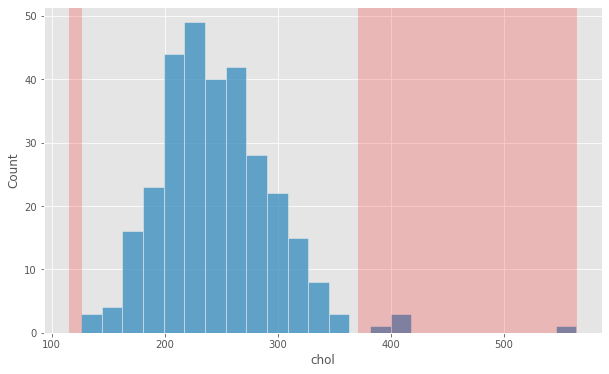

In [26]:
q25, q75 = np.quantile(df['chol'], 0.25), np.quantile(df['chol'], 0.75)
iqr = q75 - q25
cut_off = iqr * 1.5
lower, upper = q25 - cut_off, q75 + cut_off
plt.figure(figsize = (10,6));
sns.histplot(df.chol);
plt.axvspan(xmin = lower,xmax= df.chol.min(),alpha=0.2, color='red');
plt.axvspan(xmin = upper,xmax= df.chol.max(),alpha=0.2, color='red');

*Removing the outliers*

Total number of outlier in age are 0
---------------------------------------
Total number of outlier in trestbps are 9
---------------------------------------
Total number of outlier in chol are 5
---------------------------------------
Total number of outlier in thalach are 1
---------------------------------------
Total number of outlier in oldpeak are 4
---------------------------------------


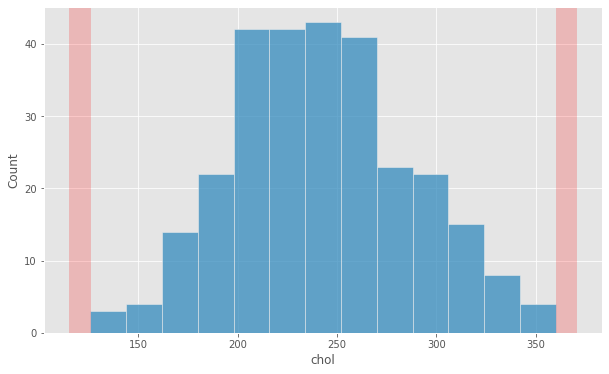

In [27]:
def out_iqr(df , column):
    
    q25, q75 = np.quantile(df[column], 0.25), np.quantile(df[column], 0.75)
    iqr = q75 - q25
    cut_off = iqr * 1.5
    lower, upper = q25 - cut_off, q75 + cut_off
    df1 = df[df[column] > upper]
    df2 = df[df[column] < lower]
    print(f"Total number of outlier in {column} are {df1.shape[0]+ df2.shape[0]}")
    print("---------------------------------------")
    index = df[(df[column] > upper)|(df[column] < lower)].index
    df.drop(index, inplace=True)

for col in cont_cols:
  out_iqr(df,col)

plt.figure(figsize = (10,6));
sns.histplot(df.chol);
plt.axvspan(xmin = lower,xmax= df.chol.min(),alpha=0.2, color='red');
plt.axvspan(xmin = upper,xmax= df.chol.max(),alpha=0.2, color='red');

# **Feature-Engineering**

Current dataset

In [28]:
print(f"Number of features: {df.shape}")
df.head(5)

Number of features: (283, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1,3,145.0,233.0,1,0,150.0,0,2.3,0,0.0,1,0
1,67.0,1,0,160.0,286.0,0,0,108.0,1,1.5,1,3.0,2,2
2,67.0,1,0,120.0,229.0,0,0,129.0,1,2.6,1,2.0,3,1
3,37.0,1,2,130.0,250.0,0,1,187.0,0,3.5,0,0.0,2,0
4,41.0,0,1,130.0,204.0,0,0,172.0,0,1.4,2,0.0,2,0


***Generating new features from the existing ones***

In [29]:
def fe_creation(df):
    df['age2'] = df['age']//10
    df['trestbps2'] = df['trestbps']//10 
    df['chol2'] = df['chol']//40
    df['thalach2'] = df['thalach']//40
    df['oldpeak2'] = df['oldpeak']//0.4
    for i in ['sex', 'age2', 'fbs', 'restecg', 'exang','thal', ]:
        for j in ['cp','trestbps2', 'chol2', 'thalach2', 'oldpeak2', 'slope', 'ca']:
            df[i + "_" + j] = df[i].astype('str') + "_" + df[j].astype('str')
    return df
df = fe_creation(df)
print(f"Number of features: {df.shape}")
df.head(5)

Number of features: (283, 61)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,...,exang_oldpeak2,exang_slope,exang_ca,thal_cp,thal_trestbps2,thal_chol2,thal_thalach2,thal_oldpeak2,thal_slope,thal_ca
0,63.0,1,3,145.0,233.0,1,0,150.0,0,2.3,...,0_5.0,0_0,0_0.0,1_3,1_14.0,1_5.0,1_3.0,1_5.0,1_0,1_0.0
1,67.0,1,0,160.0,286.0,0,0,108.0,1,1.5,...,1_3.0,1_1,1_3.0,2_0,2_16.0,2_7.0,2_2.0,2_3.0,2_1,2_3.0
2,67.0,1,0,120.0,229.0,0,0,129.0,1,2.6,...,1_6.0,1_1,1_2.0,3_0,3_12.0,3_5.0,3_3.0,3_6.0,3_1,3_2.0
3,37.0,1,2,130.0,250.0,0,1,187.0,0,3.5,...,0_8.0,0_0,0_0.0,2_2,2_13.0,2_6.0,2_4.0,2_8.0,2_0,2_0.0
4,41.0,0,1,130.0,204.0,0,0,172.0,0,1.4,...,0_3.0,0_2,0_0.0,2_1,2_13.0,2_5.0,2_4.0,2_3.0,2_2,2_0.0


**Label Encode all the categorical columns**

In [30]:
categorical_columns = []
numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
features = df.columns.values.tolist()
for col in features:
    if df[col].dtype in numerics: continue
    categorical_columns.append(col)

for col in categorical_columns:
    if col in df.columns:
        le = LabelEncoder()
        le.fit(list(df[col].astype(str).values))
        df[col] = le.transform(list(df[col].astype(str).values))

In [31]:
df.dtypes.value_counts()

int64      50
float64    11
dtype: int64

In [32]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,...,exang_oldpeak2,exang_slope,exang_ca,thal_cp,thal_trestbps2,thal_chol2,thal_thalach2,thal_oldpeak2,thal_slope,thal_ca
0,63.0,1,3,145.0,233.0,1,0,150.0,0,2.3,...,5,0,0,5,4,2,3,7,2,1
1,67.0,1,0,160.0,286.0,0,0,108.0,1,1.5,...,12,4,8,6,14,9,5,12,6,8
2,67.0,1,0,120.0,229.0,0,0,129.0,1,2.6,...,15,4,7,10,18,14,10,24,9,12
3,37.0,1,2,130.0,250.0,0,1,187.0,0,3.5,...,8,0,0,8,11,8,7,17,5,5
4,41.0,0,1,130.0,204.0,0,0,172.0,0,1.4,...,3,2,0,7,11,7,7,12,7,5


# **Feature-Selection**

**In this section, we will be using various feature selection techniques to find the optimium set of features and then takes the intersection of the features generated by the different techniques.**

In [33]:
X = df.drop('target',axis=1)
y = df.target
num_features_opt = 25   # the number of features that we need to choose as a result
num_features_max = 35   # the somewhat excessive number of features, which we will choose at each stage
features_best = []

## **Features selection with Pearsons correlation**

> ![](https://miro.medium.com/max/2919/1*OgRpdNHGsxjrWwqolc1jpw.png)

In [34]:
threshold = 0.9
# Absolute value correlation matrix
corr_matrix = df.corr().abs().round(2)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# Select columns with correlations above threshold
collinear_features = [column for column in upper.columns if any(upper[column] > threshold)]
features_filtered = df.drop(columns = collinear_features)
print('The number of features that passed the collinearity threshold: ', features_filtered.shape[1])
features_best.append(features_filtered.columns.tolist())
features_best

The number of features that passed the collinearity threshold:  28


[['age',
  'sex',
  'cp',
  'trestbps',
  'chol',
  'fbs',
  'restecg',
  'thalach',
  'exang',
  'oldpeak',
  'slope',
  'ca',
  'thal',
  'target',
  'thalach2',
  'sex_cp',
  'sex_thalach2',
  'sex_oldpeak2',
  'sex_ca',
  'fbs_cp',
  'fbs_trestbps2',
  'fbs_thalach2',
  'fbs_oldpeak2',
  'fbs_slope',
  'fbs_ca',
  'restecg_cp',
  'restecg_oldpeak2',
  'exang_cp']]

## **Feature Selection with Linear SVC**

In [35]:
lsvc = LinearSVC(C=0.1, penalty="l1", dual=False).fit(X, y)
model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(X)
X_selected_df = pd.DataFrame(X_new, columns=[X.columns[i] for i in range(len(X.columns)) if model.get_support()[i]])
features_best.append(X_selected_df.columns.tolist())
# features_best

## **Feature selection with Lasso**

In [36]:
lasso = LassoCV(cv=10).fit(X, y)
model = SelectFromModel(lasso, prefit=True)
X_new = model.transform(X)
X_selected_df = pd.DataFrame(X_new, columns=[X.columns[i] for i in range(len(X.columns)) if model.get_support()[i]])
features_best.append(X_selected_df.columns.tolist())
# features_best

## **Feature Selection with Chi-2**

In [37]:
bestfeatures = SelectKBest(score_func=chi2, k='all')
fit = bestfeatures.fit(X, y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']  #naming the dataframe columns
features_best.append(featureScores.nlargest(num_features_max,'Score')['Feature'].tolist())
# print(featureScores.nlargest(len(dfcolumns),'Score')) 

## **Feature Selection by Recursive Feature Elimination (RFE) and Logistic Regression**

In [38]:
rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=num_features_max, step=10, verbose=5)
rfe_selector.fit(X, y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()
# print(str(len(rfe_feature)), 'selected features')
features_best.append(rfe_feature)
# features_best

Fitting estimator with 60 features.
Fitting estimator with 50 features.
Fitting estimator with 40 features.


## **Feature Selection by Recursive Feature Elimination (RFE) and Random Forest Classifier**

In [39]:
embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=200), threshold='1.25*median')
embeded_rf_selector.fit(X, y)
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
print(str(len(embeded_rf_feature)), 'selected features')
features_best.append(embeded_rf_feature)
# features_best

18 selected features


## **Feature Selection using Variance Threshold**

In [40]:
selector = VarianceThreshold(threshold=10)
np.shape(selector.fit_transform(df))
features_best.append(list(np.array(df.columns)[selector.get_support(indices=False)]))
# features_best

***Features that occur atleast once in outputs of one of the above feature selection method***.

In [41]:
main_cols_max = features_best[0]
for i in range(len(features_best)-1):
    main_cols_max = list(set(main_cols_max) | set(features_best[i+1]))
# main_cols_max
len(main_cols_max)

55

***Features that occur in all the outputs of the above feature selection methods.***

In [42]:
main_cols_min = features_best[0]
for i in range(len(features_best)-1):
    main_cols_min = list(set(main_cols_min).intersection(set(features_best[i+1])))
main_cols_min

['age']

***Most common features in all list of features***

In [43]:
main_cols = []
main_cols_opt = {feature_name : 0 for feature_name in df.columns.tolist()}
for i in range(len(features_best)):
    for feature_name in features_best[i]:
        main_cols_opt[feature_name] += 1
df_main_cols_opt = pd.DataFrame.from_dict(main_cols_opt, orient='index', columns=['Num'])
df_main_cols_opt.sort_values(by=['Num'], ascending=False).head(num_features_opt)

,Num
age,7
sex_oldpeak2,6
thal_oldpeak2,6
chol,6
thalach,6
exang_oldpeak2,6
ca,6
fbs_oldpeak2,6
sex_ca,6
thal_chol2,5


*Adding **target** to the selected features*

In [44]:
main_cols = df_main_cols_opt.nlargest(num_features_opt, 'Num').index.tolist()
if not 'target' in main_cols:
    main_cols.append('target')
# main_cols

***Saving the selected features***

In [45]:
df_fs = df[main_cols]
df_fs.to_csv('final_data_FE+FS.csv',index=False)

# **Data-Preparation**

In [46]:
df = df_fs
print(f"Shape: {df.shape}")
df.sample(5)

Shape: (283, 26)


,age,chol,thalach,ca,sex_oldpeak2,sex_ca,fbs_oldpeak2,exang_oldpeak2,thal_oldpeak2,cp,...,thal_trestbps2,thal_chol2,thal_ca,oldpeak,oldpeak2,sex_trestbps2,sex_chol2,age2_cp,age2_trestbps2,target
52,41.0,172.0,158.0,0.0,8,4,0,0,18,0,...,17,13,10,0.0,0.0,10,8,5,7,1
39,61.0,330.0,169.0,0.0,0,0,0,0,9,0,...,11,10,5,0.0,0.0,3,5,13,24,1
144,53.0,226.0,111.0,0.0,8,4,0,9,18,0,...,20,14,10,0.0,0.0,13,9,9,16,0
192,59.0,271.0,182.0,0.0,8,4,0,0,9,0,...,11,8,5,0.0,0.0,12,10,9,15,0
48,44.0,219.0,188.0,0.0,8,4,0,0,9,1,...,11,7,5,0.0,0.0,12,9,6,9,0


In [47]:
X = df.drop('target',axis=1)
y = df.target

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (283, 25)
y shape: (283,)


## **SMOTE**

* *The distribution of class labels in the target variable are somewhat imbalanced, with S4,S3,S2,S1 and H having 11,29,33,52,158 samples respectively.*

* *With such few samples in S1,S2,S3 and S4 training a model to identify these classes isn't pragmatic. Hence, in order to avoid the class imbalance problem, we will perform **synthetic minority oversampling (SMOTE)** to generate samples of the minority classes*

>![](https://miro.medium.com/max/1400/1*GJY7UnJ4WCzqgtrfkCvkdA.png)

## ***Splitting the data into training and testing sets***

## **Helper Functions**

1. `plot_roc_cm(model_name,cm,n_classes, fpr, tpr, roc_auc,class_report_df,average = "macro"):`
  * **model_name**: Name of the algorithm
  * **cm**: Confusion matrix
  * **n_classes**: Number of unique class labels in the target variable
  * **fpr**: Numpy array of false positive rate values corresponding to each class.
  * **tpr**: Numpy array of true positive rate values corresponding to each class.
  * **roc_auc**: Numpy array of auc values corresponding to each class.
  * **class_report_df**: output dataframe of the **class_report** helper function.

2. `class_report(model_name,y_true, y_pred, y_score=None, average='macro'):`
  * **model_name**: Name of the algorithm
  * **y_true**: True label values
  * **y_pred**: Predicted label values
  * **y_score**: Predicted probability of class label values
  * **average**: "micro","macro".

3. `kfold(model,n_splits,X,y):`

  * **model**: Model on which k-fold cross validation is to be performed
  * **n_splits**: Number of folds/splits
  * **X**: Features
  * **y**: target vector.

4. `grid_search(estimator, params, X_train,y_train,cv=10):`

  * estimator: Model using which gridsearch is to be performed
  * params: Parameter grid
  * X_train: Training features
  * y_train: Training target vector
  * cv: Nummber of times cross-validation is to performed.



# **Conclusion**



*   As seen from the graph above, stacking and voting classifiers out perform all the other models in terms of Accuracy, F-1 Score and AUC.
*   Detection of heart diseases is inherently a very tough task, and using machine learning models, can help make this task a little easier.

